# COMP41680 - Ryan Jennings 19205824
### Tasks:
In this assignment you should complete all of the following tasks:
1. Select **three** review categories of your choice. Scrape all reviews for each category and store them as three separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”).
2. For each of the three category datasets:
a. From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.
b. Build a classification model to distinguish between “positive” and “negative” reviews using **one** of the following classifiers:
Naive Bayes, Logistic Regression, Random Forests
c. Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.
3. Evaluate the performance of each of your three classification models when applied to data from the other two selected categories. That is, for the selected categories (A,B,C), run the experiments:
   a. Train a classification model on the performance on data from “Category
b. Train a classification model on the performance on data from “Category
c. Train a classification model on the performance on data from “Category
data from “Category A”. Evaluate its B” and data from “Category C”.
data from “Category B”. Evaluate its A” and data from “Category C”.
data from “Category C”. Evaluate its A” and data from “Category B”.

Import the standard packages for working with data for plotting and analysis

In [168]:
import csv
import re

from typing import Any, Dict, List, Tuple

import requests

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

# Use seaborn style plots
sns.set()

JsonType = Dict[str, Any]

## Task 1
The 3 review categories I chose were:
- Gym
- Hotels
- Restaurants

In [8]:
def scrape_review(title: str) -> JsonType:
    """
    Scrape a review from the given samples based on category name

    Keyword arguments:
    title: str - The category name to scrape reviews for

    Return: JsonType - List of reviews in Dicts
    """
    scraped_data: JsonType = []
    home_url: str = "http://mlg.ucd.ie/modules/yalp/"
    url_map: Dict[str, str] = get_title_to_link_map(url=home_url)

    res = requests.get(f"{home_url}{url_map[title]}")
    category_page_soup = BeautifulSoup(res.text, 'html.parser')
    # Find all business links from the category
    review_links_page = category_page_soup.find_all('a', href=True)
    review_links: List[str] = [link['href'] for link in review_links_page][1:]
    for rlink in review_links:
        review_page = requests.get(f"{home_url}{rlink}")
        review_soup = BeautifulSoup(review_page.text, 'html.parser')
        # Find all individual reviews for the business
        reviews = review_soup.find_all("div", class_="review")

        # Seperate into text and rating (positive/negative)
        for review in reviews:
            review_rating = review.find('p', class_="rating").find('img')['alt'][0]
            review_text = review.find('p', class_="review-text")
            scraped_data.append({
                'text': review_text.text,
                'rating': (1 if int(review_rating) > 3 else 0) # 1 for a positive review, 0 for a negative review
            })
    return scraped_data

def get_title_to_link_map(url: str) -> Dict[str, str]:
    """
    For the main page get the title names and their corresponding links

    Keyword arguments:
    url: str - The base url for the category page

    Return: Dict[str, str] - Map of category names to category links
    """
    res = requests.get(url)
    html_soup: BeautifulSoup = BeautifulSoup(res.text, 'html.parser')
    links = html_soup.find_all('a', href=True)
    return {re.sub('Category: ', '', link.get_text()): link['href'] for link in links}

In [9]:
def write_scraped_data_to_csv(data: JsonType, file_name: str) -> None:
    """
    Write the ratings data into a csv file

    Keyword arguments:
    data: JsonType - List of rating Dicts to write to a csv file
    file_name: str - The name of the file to store the data in

    Return: None
    """
    with open(file_name, 'w') as csv_file:
        csv_writer = csv.DictWriter(csv_file, ['text', 'rating'], delimiter=',')
        csv_writer.writeheader()
        for row in data:
            csv_writer.writerow(row)

Call the scrape functions for the 3 selected topics

In [21]:
gym_data = scrape_review('Gym')

In [39]:
hotel_data = scrape_review('Hotels')

In [40]:
restaurant_data = scrape_review('Restaurants')

Write the scraped data into separate csv files

In [41]:
write_scraped_data_to_csv(data=gym_data, file_name='gym.csv')
write_scraped_data_to_csv(data=hotel_data, file_name='hotel.csv')
write_scraped_data_to_csv(data=restaurant_data, file_name='restaurant.csv')

## Task 2
For each of the three category datasets:
1. From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.
2. Build a classification model to distinguish between “positive” and “negative” reviews using **one** of the following classifiers:  
       Naive Bayes, Logistic Regression, Random Forests
3. Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.

In [176]:
gym_df = pd.read_csv('gym.csv')
hotel_df = pd.read_csv('hotel.csv')
rest_df = pd.read_csv('restaurant.csv')

The gyms on average higher more positive ratings. This could possibly be to the lower demands on gyms that just need to have good equipment and be clean while hotels and restaurants have to have a higher standard of hygiene and provide a high standard of food/facilities.  

In [147]:
print(f"Gyms positive rating percentage: {gym_df.mean()[0]*100:.2f}%")
print(f"Hotels positive rating percentage: {hotel_df.mean()[0]*100:.2f}%")
print(f"Restaurants positive rating percentage: {rest_df.mean()[0]*100:.2f}%")

Gyms positive rating percentage: 64.95%
Hotels positive rating percentage: 58.80%
Restaurants positive rating percentage: 58.10%


Text(0.5, 1.0, 'Negative and Positive Restaurant Ratings')

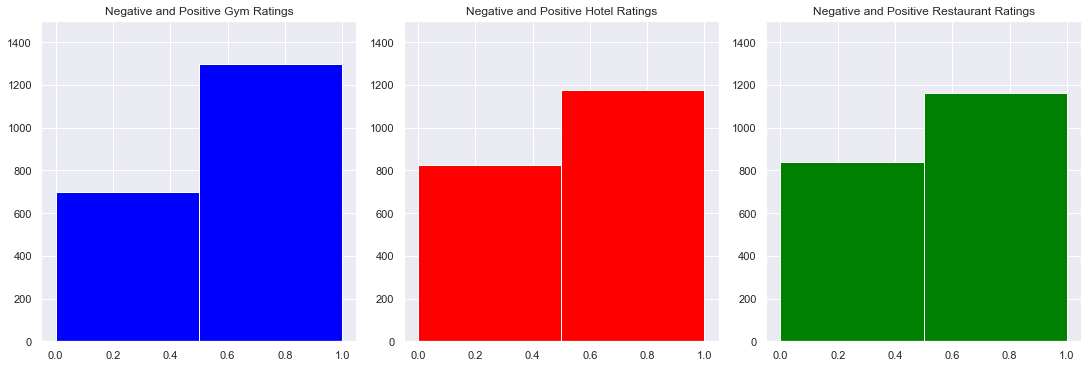

In [194]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, constrained_layout=True, figsize=(15, 5))
gym_df['rating'].hist(ax=ax0, bins=2, color='blue')
hotel_df['rating'].hist(ax=ax1, bins=2,color='red')
rest_df['rating'].hist(ax=ax2, bins=2, color='green')

ax0.set_ylim([0, 1500])
ax1.set_ylim([0, 1500])
ax2.set_ylim([0, 1500])
ax0.set_title('Negative and Positive Gym Ratings')
ax1.set_title('Negative and Positive Hotel Ratings')
ax2.set_title('Negative and Positive Restaurant Ratings')

In [25]:
# ROC Curve

TODO: Talk about the split

In [204]:
def split_data(dataframe: pd.DataFrame, train_size: float = 0.9) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Split the data into training and testing.
    I tried with the built-in sklearn `train_test_split` but doing it manually for some reason
    produced 10% better classification given the same split
    #train_gym_text, test_gym_text, train_gym_rating, test_gym_rating = \
      train_test_split(gym_df['text'], gym_df['rating'], test_size=0.1)

    Keyword argument:
    dataframe: pd.DataFrame - the DataFrame to split data for
    train_size: float - the percentage (out of 1.0) to use for training, default 90%

    Return: Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame] - Return 4 DataFrames split proportionally
    """
    por: int = int(round(dataframe['text'].count() * train_size))
    return dataframe['text'][:por], dataframe['text'][por:], dataframe['rating'][:por], dataframe['rating'][por:]

In [205]:
train_gym_text, test_gym_text, train_gym_rating, test_gym_rating = split_data(dataframe=gym_df)
train_hotel_text, test_hotel_text, train_hotel_rating, test_hotel_rating = split_data(dataframe=hotel_df)
train_rest_text, test_rest_text, train_rest_rating, test_rest_rating = split_data(dataframe=rest_df)

In [226]:
def generate_model(train_text: pd.DataFrame, train_rating: pd.DataFrame) -> Tuple[MultinomialNB, TfidfVectorizer]:
    """
    Generate the predictions based on the training data

    Keyword arguments:
    train_text: pd.DataFrame - The dataframe text for training
    train_rating: pd.DataFrame - The dataframe ratings for training

    Return: MultinomialNB - fitted Naive Bayes model
    """
    vectorizer = TfidfVectorizer(stop_words="english", min_df=5)

    train_X = vectorizer.fit_transform(train_text)
    train_Y = train_rating
    # print(f"Train data shape after vectorising: {train_X.shape}")

    model: MultinomialNB = MultinomialNB()
    model.fit(train_X, train_Y)
    return model, vectorizer

def generate_prediction(model: MultinomialNB, vec: TfidfVectorizer, test_text: pd.DataFrame) -> np.ndarray:
    """
    Generate a prediction array for a test text set

    Keyword arguments:
    model: MultinomialNB - The fitted Naive Bayes model
    vec: TfidVectorizer - The vectorizer for the model data
    test_text: pd.DataFrame - A dataframe of the test text set

    Return: np.ndarray - The predicted ratings from the fitted model
    """
    test_X = vec.transform(test_text)
    predicted_rating: np.ndarray = model.predict(test_X)
    return predicted_rating

In [227]:
gym_model, gym_vec = generate_model(train_text=train_gym_text,
                                    train_rating=train_gym_rating)
hotel_model, hotel_vec = generate_model(train_text=train_hotel_text,
                                        train_rating=train_hotel_rating)
rest_model, rest_vec = generate_model(train_text=train_rest_text,
                                      train_rating=train_rest_rating)

In [228]:
predicted_gym_rating: np.ndarray = generate_prediction(model=gym_model,
                                                       vec=gym_vec,
                                                       test_text=test_gym_text)
predicted_hotel_rating: np.ndarray = generate_prediction(model=hotel_model,
                                                         vec=hotel_vec,
                                                         test_text=test_hotel_text)
predicted_rest_rating: np.ndarray = generate_prediction(model=rest_model,
                                                        vec=rest_vec,
                                                        test_text=test_rest_text)

In [230]:
acc_gym = accuracy_score(test_gym_rating, predicted_gym_rating)
acc_hotel = accuracy_score(test_hotel_rating, predicted_hotel_rating)
acc_rest = accuracy_score(test_rest_rating, predicted_rest_rating)
print(f"Gym Review Classification accuracy: {acc_gym:.2f}")
print(f"Hotel Review Classification accuracy: {acc_hotel:.2f}")
print(f"Restaurant Review Classification accuracy: {acc_rest:.2f}")

Gym Review Classification accuracy: 0.92
Hotel Review Classification accuracy: 0.91
Restaurant Review Classification accuracy: 0.82


In [189]:
# Evaluation
# Confusion matrix
confusion_matrix(test_gym_Y, gym_predicted)

array([[ 29,  11],
       [  5, 155]])

In [190]:
test_gym_text

1800    I usually go to a different tanning company BU...
1801    This review is about my first, ever "spray tan...
1802    I had the BEST experience in spray tanning eve...
1803    This place is amazing! I go on Tuesdays during...
1804    Wow i know i just stumbled upon the coolest pl...
                              ...                        
1995    Quad is a wonderful place to exercise. I have ...
1996    Fantastic spin place! I'm back in Toronto temp...
1997    I started at Quad in January and I have enjoye...
1998    I'm taking an 8-week class at Quad right now a...
1999    Great for in the winter when I'm not riding my...
Name: text, Length: 200, dtype: object

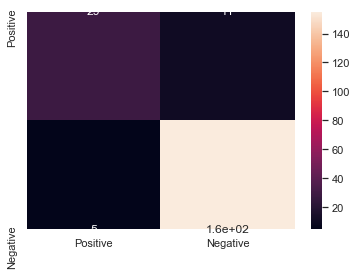

In [187]:
labels = ['Positive', 'Negative']
gym_cm = pd.DataFrame(confusion_matrix(test_gym_Y, gym_predicted), index=labels, columns=labels)
sns.heatmap(gym_cm, annot=True)

## Task 3
Evaluate the performance of each of your three classification models when applied to data from the other two selected categories. That is, for the selected categories (A, B, C), run the experiments:
1. Train a classification model on the performance on data from “Category A”. Evaluate its performance on data from "Category B” and data from “Category C”.  
2. Train a classification model on the performance on data from “Category B”. Evaluate its performance on data from "Category A” and data from “Category C”.  
3. Train a classification model on the performance on data from “Category C”. Evaluate its performance on data from "Category A” and data from “Category B”.  
